In [ ]:
# === BLOQUE 3 – Entrenamiento LightGBM  ===

# 1) Instalar LightGBM

%pip install lightgbm --quiet


# 2) Importar librerías
import pandas as pd
import numpy as np
import lightgbm as lgb
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os


# 3) Rutas reutilizando ROOT e INTERMEDIOS
ROOT= Path.cwd().parent

INTERMEDIOS = ROOT / "intermedios"
SALIDAS     = ROOT / "outputs"     
FEATURES_DIR = ROOT / "features"
PRED_PATH = SALIDAS / "pred_modelo_lgbm_Best.csv"

BASE_OUTPUTS   = r'C:\Users\Elisabeth\Desktop\MAESTRIA_AUSTRAL\Labo_III\labo3-2025v\entrega_final\output'

# 4) Carga de features desde pkl
print("📥 Cargando dataset de features…")
df = pd.read_pickle(FEATURES_DIR/"dataset_features_product_id.pkl")
print(f"✅ Dataset: {df.shape[0]} filas, {df.shape[1]} columnas.")




#print(df.dtypes.value_counts())

#print(df.dtypes['n_customers'])


# 5) Asegurar columna target
if 'target' not in df.columns:
    df = df.sort_values(['product_id','periodo']).reset_index(drop=True)
    df['target'] = df.groupby('product_id')['tn'].shift(-2)

# 6) Filtrar y log-transform
df = df[df['target'].notna()].reset_index(drop=True)
df['target_log'] = np.log1p(df['target'].clip(lower=0))

# 7) Reducir cardinalidad en categóricas
def reducir_card(serie, max_unique=30):
    top = serie.value_counts().nlargest(max_unique).index
    return serie.where(serie.isin(top), other='Other')
for col in ['cat1','cat2','cat3']:
    if col in df.columns:
        df[col] = df[col].astype('category')
        if 'Other' not in df[col].cat.categories:
            df[col] = df[col].cat.add_categories(['Other'])
        df[col] = reducir_card(df[col]).astype('category')

# 8) Definir lista de features dinámicamente
print("🔄 Definiendo lista de features…")
exclude = [
    #'cluster_dtw',
    #'tn_rollmax2',
    #'tn_roll2',
    #'tn_mean_all',
    'share_total',
    'product_id',
    'n_customers',
    'cat2','cat3',
    'period', 'periodo','prod_start',
    'target','target_log','tn',
    'brand','cust_request_qty','cust_request_tn',
    'plan_precios_cuidados','sku_size'
]

features = [
    c for c in df.columns
    if c not in exclude and pd.api.types.is_numeric_dtype(df[c])
]

categ_feats = [c for c in ['cat1',
                           'cluster_dtw'
                           ] if c in features]

print(f"✅ {len(features)} features seleccionadas.")

# 9) Split temporal train/test
max_ord = df['period_ordinal'].max()
train   = df[df['period_ordinal'] <= max_ord - 2]
test    = df[df['period_ordinal'] >  max_ord - 2]
X_train = train[features];  y_train = train['target_log']
X_test  = test[features];   y_test  = test['target_log']
y_real  = test['target']

# 10) Entrenamiento LightGBM

dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=categ_feats)
dvalid = lgb.Dataset(X_test,  label=y_test,  reference=dtrain, categorical_feature=categ_feats)
params = {
    'objective':'regression','metric':'mae','boosting_type':'gbdt',
    'max_depth': 10, 'learning_rate': 0.05663964996081039, 'min_child_weight': 3, 'subsample': 0.8316655287432297,
    'num_leaves': 39, 'feature_fraction': 0.8247124868682788, 'bagging_fraction': 0.9595500390363261, 'bagging_freq': 8,
    'max_bin': 652, 'colsample_bytree': 0.8474007166109918, 'reg_alpha': 0.8217385123006359, 'reg_lambda': 0.9295570679904743, 'n_estimators': 112,'min_child_samples':20,
    'random_state':42,'verbosity':-1
}
print("🚀 Entrenando LightGBM…")
model = lgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain, dvalid],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)
print("✅ Entrenamiento completado.")





# 13) Evaluación en test
pred_log = model.predict(X_test); pred = np.expm1(pred_log)
test['tn_pred'] = pred
mae_val = mean_absolute_error(y_real, pred)
rmse_val = np.sqrt(mean_squared_error(y_real, pred))
print(f"🧪 Test MAE: {mae_val:.3f}, RMSE: {rmse_val:.3f}")

# 14) Predicciones último periodo
df_pred = df[df['period_ordinal']==max_ord]
X_pred  = df_pred[features]



out = pd.DataFrame({'product_id': df_pred['product_id'], 'tn_pred': np.expm1(model.predict(X_pred))})



Note: you may need to restart the kernel to use updated packages.
📥 Cargando dataset de features…
✅ Dataset: 28080 filas, 592 columnas.
🔄 Definiendo lista de features…
✅ 577 features seleccionadas.
🚀 Entrenando LightGBM…
Training until validation scores don't improve for 50 rounds
[100]	training's l1: 0.183176	valid_1's l1: 0.283786
Did not meet early stopping. Best iteration is:
[91]	training's l1: 0.18788	valid_1's l1: 0.280448
✅ Entrenamiento completado.
🧪 Test MAE: 8.956, RMSE: 27.907


C:\Users\Elisabeth\AppData\Local\Temp\ipykernel_13448\3752573117.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['tn_pred'] = pred


In [5]:
out.shape[0]

780

In [ ]:
#Guardado de Prediccion Final
out.to_csv(PRED_PATH, index=False)
print(f"💾 Guardado completado en: {PRED_PATH}")

💾 Guardado completado en: c:\Users\Elisabeth\Desktop\MAESTRIA_AUSTRAL\Labo_III\labo3-2025v\outputs\pred_modelo_lgbm_Best.csv


Feature Importance

🔍 Top 20 features por importancia normalizada:
           feature  importance_gain_norm
       tn_rollmax2              0.392525
          tn_roll2              0.342802
       tn_mean_all              0.104061
          tn_roll4              0.028303
      tn_rollmax11              0.017562
          tn_roll3              0.014357
        tn_max_all              0.011777
          tn_roll5              0.007274
meses_ceros_consec              0.006690
     tn_count_zero              0.005989
       tn_rollmax8              0.005623
         tn_roll11              0.005470
        tn_pct_all              0.005283
       tn_rollmax7              0.003364
       tn_rollmax3              0.003004
     tn_max_last_3              0.002862
             month              0.002686
    tn_max_last_10              0.002520
      tn_rollmin11              0.001721
         tn_roll10              0.001486


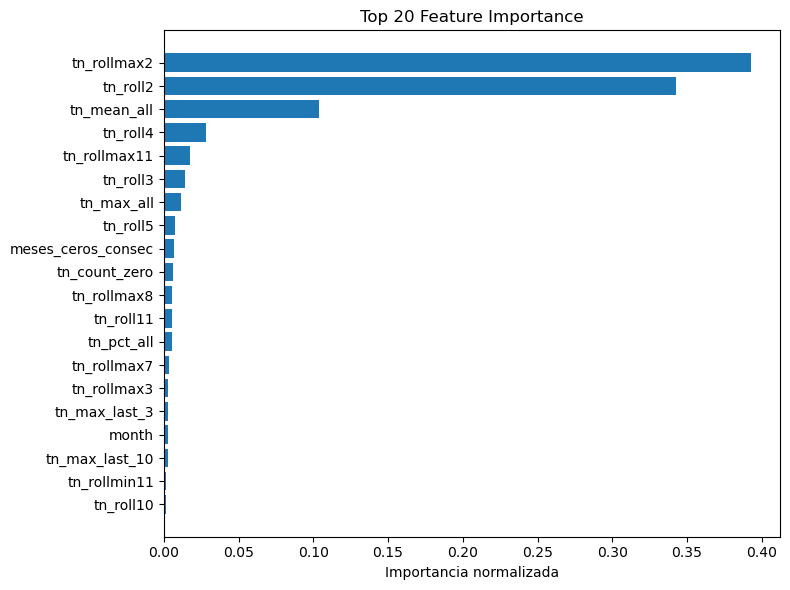

In [8]:
# 11) Exportar feature importance
imp_gain  = model.feature_importance(importance_type='gain')
imp_split = model.feature_importance(importance_type='split')
names     = model.feature_name()
norm_gain = imp_gain / imp_gain.sum()
df_imp = pd.DataFrame({
    'feature':names,'importance_gain':imp_gain,
    'importance_gain_norm':norm_gain,'importance_split':imp_split
}).sort_values('importance_gain', ascending=False)
#df_imp.to_csv(IMP_PATH, index=False)

# 11) Visualizar feature importance
imp_gain  = model.feature_importance(importance_type='gain')
names     = model.feature_name()
norm_gain = imp_gain / imp_gain.sum()

df_imp = pd.DataFrame({
    'feature':              names,
    'importance_gain_norm': norm_gain,
}).sort_values('importance_gain_norm', ascending=False)

# Mostrar top 20 en consola
print("🔍 Top 20 features por importancia normalizada:")
print(df_imp.head(20).to_string(index=False))

# (Opcional) Gráfico de barras horizontal
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
top20 = df_imp.head(20)[::-1]  # invertir para gráfico
plt.barh(top20['feature'], top20['importance_gain_norm'])
plt.xlabel('Importancia normalizada')
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()


Test Validacion 201912

In [12]:
df_valid = test[test['periodo'] == 201910].copy()

df_valid['abs_error'] = (df_valid['target'] - df_valid['tn_pred']).abs()
df_valid['rel_error'] = (df_valid['abs_error'] / df_valid['target'])
total_error = df_valid['abs_error'].sum()
total_sales = df_valid['target'].sum()
tfe = total_error / total_sales
print(f"\n📉 Total Forecast Error (TFE): {tfe:.4f}")


📉 Total Forecast Error (TFE): 0.2548


In [ ]:
# 14. Productos con mayor error
top_errores = df_valid.sort_values('abs_error', ascending=False)

print("\n🔍 Top productos con mayor error absoluto:")
print(top_errores[['product_id', 'target', 'tn_pred', 'abs_error','rel_error']])



🔍 Top productos con mayor error absoluto:
       product_id       target      tn_pred   abs_error  rel_error
33          20001  1504.688599  1072.377715  432.310884   0.287309
407         20012   173.130035   334.821354  161.691319   0.933930
271         20008   195.368546   347.529457  152.160912   0.778840
475         20014   272.028107   390.193328  118.165221   0.434386
781         20023   181.132767   283.990366  102.857599   0.567857
...           ...          ...          ...         ...        ...
22473       20967     1.554080     1.563430    0.009350   0.006017
17033       20674     8.385390     8.377883    0.007507   0.000895
24037       21077     0.215840     0.209910    0.005930   0.027473
16081       20637     4.749640     4.752190    0.002550   0.000537
24819       21140     0.556940     0.556214    0.000726   0.001303

[780 rows x 5 columns]


In [25]:
cols = ['product_id', 'target', 'tn_pred', 'abs_error', 'rel_error']
top_errores = top_errores[cols]

In [26]:


 #Definir ruta de salida (reusa BASE_OUTPUTS si ya la tienes)
 
BASE_OUTPUTS   = r'C:\Users\Elisabeth\Desktop\MAESTRIA_AUSTRAL\Labo_III\labo3-2025v\entrega_final\output'
ERROR_CSV_PATH = os.path.join(BASE_OUTPUTS, 'error_modelo_lgbm.csv')

# Exportar a CSV
top_errores.to_csv(ERROR_CSV_PATH, index=False)

print(f"✅ Resultados exportados a: {ERROR_CSV_PATH}")




✅ Resultados exportados a: C:\Users\Elisabeth\Desktop\MAESTRIA_AUSTRAL\Labo_III\labo3-2025v\entrega_final\output\error_modelo_lgbm.csv


In [27]:
top_errores.head()

,product_id,target,tn_pred,abs_error,rel_error
33,20001,1504.688599,1072.377715,432.310884,0.287309
407,20012,173.130035,334.821354,161.691319,0.933930
271,20008,195.368546,347.529457,152.160912,0.778840
475,20014,272.028107,390.193328,118.165221,0.434386
781,20023,181.132767,283.990366,102.857599,0.567857
